# Packages

In [1]:
# packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Data

In [2]:
import pandas as pd

In [3]:
# Load the dataset
data_path = 'earthquake_data.csv'  # Adjust the path as necessary
data = pd.read_csv(data_path).reset_index()
data.drop(columns=['nst'], inplace=True)

# Convert date_time to datetime format for easier handling
data['date_time'] = pd.to_datetime(data['date_time'], format='%d-%m-%Y %H:%M')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      782 non-null    int64         
 1   title      782 non-null    object        
 2   magnitude  782 non-null    float64       
 3   date_time  782 non-null    datetime64[ns]
 4   cdi        782 non-null    int64         
 5   mmi        782 non-null    int64         
 6   alert      415 non-null    object        
 7   tsunami    782 non-null    int64         
 8   sig        782 non-null    int64         
 9   net        782 non-null    object        
 10  dmin       782 non-null    float64       
 11  gap        782 non-null    float64       
 12  magType    782 non-null    object        
 13  depth      782 non-null    float64       
 14  latitude   782 non-null    float64       
 15  longitude  782 non-null    float64       
 16  location   777 non-null    object        
 1

# Dealing With Missing Values

## Locations Variables

### From location get city and country

In [5]:
def func_city(location):
    try:
        city = location.split(', ')[0]
        return city
    except:
        return None
    
def func_country(location):
    try:
        city = location.split(', ')[1]
        return city
    except:
        return None
    
def func_distance(title):
    try:
        p = title.split('km')[0]
        return int(p.split(' - ')[-1])
    except:
        return None
    
data['city'] = data.location.apply(lambda x: func_city(x))
data['country'] = data.location.apply(lambda x: func_country(x))
data['distance'] = data.title.apply(lambda x: func_distance(x))

### From latitude, longitude fill city, country, continent that remains

In [6]:
from sklearn.neighbors import BallTree

In [7]:
def get_location_missing_info(data, loc):

    complete_info = data[data[loc].isnull()==False]
    incomplete_info = data[data[loc].isnull()==True]

    # Convert latitude and longitude to radians for distance calculation
    complete_coords = np.radians(complete_info[['latitude', 'longitude']])
    incomplete_coords = np.radians(incomplete_info[['latitude', 'longitude']])

    # Create a BallTree for efficient distance calculation
    tree = BallTree(complete_coords, metric='haversine')

    # Find the index of the closest point in the complete dataset for each point in the incomplete dataset
    distances, indices = tree.query(incomplete_coords, k=1)

    # Use the indices to map the closest neighbor's continent, country, and location to the incomplete records
    incomplete_info['nearest_index'] = indices.flatten()
    incomplete_info_mapped = incomplete_info.apply(lambda x: complete_info.iloc[x['nearest_index']][[loc]], axis=1)

    # Update the original dataframe with the inferred values
    data.loc[incomplete_info.index, [loc]] = incomplete_info_mapped.values

    return data

    
# select variable
loc = 'continent'
data = get_location_missing_info(data, loc)

loc = 'country'
data = get_location_missing_info(data, loc)

loc = 'city'
data = get_location_missing_info(data, loc)

/tmp/ipykernel_14575/2409448472.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_info['nearest_index'] = indices.flatten()


/tmp/ipykernel_14575/2409448472.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_info['nearest_index'] = indices.flatten()
/tmp/ipykernel_14575/2409448472.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_info['nearest_index'] = indices.flatten()


## Earthquake Statistics

### Alert Variable

In [8]:
data.alert.value_counts(dropna=False)

NaN       367
green     325
yellow     56
orange     22
red        12
Name: alert, dtype: int64

In [9]:
from sklearn.preprocessing import LabelEncoder

data_drop_na_alert = data.dropna(subset=['alert'])

# Encoding categorical variables
le_magtype = LabelEncoder()
data_drop_na_alert['magType_encoded'] = le_magtype.fit_transform(data_drop_na_alert['magType'])

# Handling 'alert' variable - encoding non-missing values
le_alert = LabelEncoder()
data_drop_na_alert['alert_encoded'] = le_alert.fit_transform(data_drop_na_alert['alert'])

# Display encoded features
data_drop_na_alert[['magType', 'magType_encoded', 'alert', 'alert_encoded']].head()

# Now, let's calculate Spearman's rank correlation for numerical features against 'alert_encoded'
correlation_matrix = data_drop_na_alert[['magnitude', 'cdi', 'mmi', 'tsunami', 'sig', 'dmin', 'gap', 'depth', 'magType_encoded', 'alert_encoded']].corr(method='spearman')

# Display the correlation matrix, focusing on the 'alert_encoded' column
correlation_matrix['alert_encoded'].sort_values(ascending=False)



/tmp/ipykernel_14575/1814002223.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop_na_alert['magType_encoded'] = le_magtype.fit_transform(data_drop_na_alert['magType'])
/tmp/ipykernel_14575/1814002223.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_drop_na_alert['alert_encoded'] = le_alert.fit_transform(data_drop_na_alert['alert'])


alert_encoded      1.000000
mmi                0.572444
cdi                0.515208
sig                0.492928
magnitude          0.198298
gap                0.060218
magType_encoded   -0.056187
tsunami           -0.086608
depth             -0.108756
dmin              -0.158862
Name: alert_encoded, dtype: float64

In [10]:
data_drop_na_alert.alert.value_counts(dropna=False)

green     325
yellow     56
orange     22
red        12
Name: alert, dtype: int64

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       163
           1       0.41      0.82      0.55        11
           2       1.00      1.00      1.00         6
           3       0.32      0.64      0.43        28

    accuracy                           0.75       208
   macro avg       0.68      0.81      0.71       208
weighted avg       0.88      0.75      0.79       208



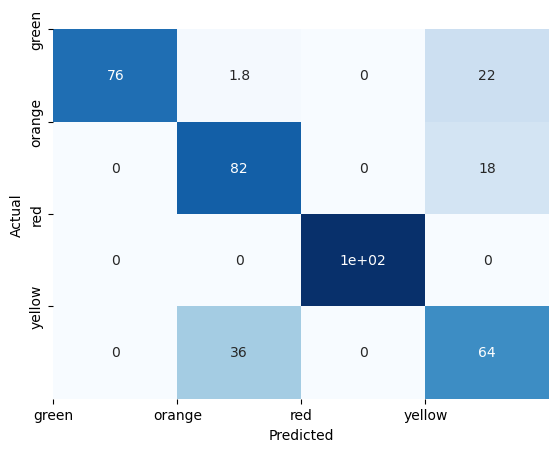

In [11]:
# classification model for 'alert' variable 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score


# set X and y
X = data_drop_na_alert[['cdi', 'mmi', 'sig', 'magnitude']]
y = data_drop_na_alert['alert_encoded']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# compute class weights
class_weights = dict(y.value_counts(normalize=True))

# Standardize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# # apply oversampling with SMOTE
smote = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# create the model
model = SVC(C=0.5, class_weight='balanced', random_state=42, probability=True)


# fit the model
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate the model
print(classification_report(y_test, y_pred))

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# normalize the confusion matrix
conf_matrix = conf_matrix / conf_matrix.sum(axis=1).reshape(-1, 1)*100

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=[0, 1, 2, 3], labels=le_alert.classes_)
plt.yticks(ticks=[0, 1, 2, 3], labels=le_alert.classes_)
plt.show()


In [12]:
# Fill missing values in 'alert' with the model trained
X_missing = data[data['alert'].isnull()][['cdi', 'mmi', 'sig', 'magnitude']]
X_missing = scaler.transform(X_missing)
y_missing = model.predict(X_missing)
data.loc[data['alert'].isnull(), 'alert'] = le_alert.inverse_transform(y_missing)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   index      782 non-null    int64         
 1   title      782 non-null    object        
 2   magnitude  782 non-null    float64       
 3   date_time  782 non-null    datetime64[ns]
 4   cdi        782 non-null    int64         
 5   mmi        782 non-null    int64         
 6   alert      782 non-null    object        
 7   tsunami    782 non-null    int64         
 8   sig        782 non-null    int64         
 9   net        782 non-null    object        
 10  dmin       782 non-null    float64       
 11  gap        782 non-null    float64       
 12  magType    782 non-null    object        
 13  depth      782 non-null    float64       
 14  latitude   782 non-null    float64       
 15  longitude  782 non-null    float64       
 16  location   777 non-null    object        
 1

In [19]:
data

,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,dmin,gap,magType,depth,latitude,longitude,location,continent,country,city,distance
0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,2022-11-22 02:03:00,8,7,green,1,768,us,0.509,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands,Malango,18.0
1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,2022-11-18 13:37:00,4,4,green,0,735,us,2.229,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",Asia,Indonesia,Bengkulu,204.0
2,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,2022-11-11 10:48:00,5,5,green,1,833,us,1.865,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",Oceania,Tonga,Neiafu,205.0
3,M 7.0 - south of the Fiji Islands,7.0,2022-11-09 09:51:00,4,3,green,1,755,us,4.578,26.0,mwb,660.000,-26.0442,178.381,the Fiji Islands,Oceania,Fiji,the Fiji Islands,NaN
4,M 6.8 - south of the Fiji Islands,6.8,2022-11-09 09:38:00,1,3,green,1,711,us,4.678,22.0,mww,630.379,-25.9678,178.363,the Fiji Islands,Oceania,Fiji,the Fiji Islands,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,"M 7.7 - 28 km SSW of Puerto El Triunfo, El Sal...",7.7,2001-01-13 17:33:00,0,8,green,0,912,us,0.000,0.0,mwc,60.000,13.0490,-88.660,"Puerto El Triunfo, El Salvador",North America,El Salvador,Puerto El Triunfo,28.0
773,"M 6.9 - 47 km S of Old Harbor, Alaska",6.9,2001-01-10 16:02:00,5,7,yellow,0,745,ak,0.000,0.0,mw,36.400,56.7744,-153.281,"Old Harbor, Alaska",North America,Alaska,Old Harbor,47.0
774,"M 7.1 - 16 km NE of Port-Olry, Vanuatu",7.1,2001-01-09 16:49:00,0,7,green,0,776,us,0.000,0.0,mwb,103.000,-14.9280,167.170,"Port-Olry, Vanuatu",Oceania,Vanuatu,Port-Olry,16.0
775,"M 6.8 - Mindanao, Philippines",6.8,2001-01-01 08:54:00,0,5,green,0,711,us,0.000,0.0,mwc,33.000,6.6310,126.899,"Mindanao, Philippines",Asia,Philippines,Mindanao,NaN


## Data is Full

In [18]:
data.dropna(subset=['location'], inplace=True)
data.reset_index(drop=True, inplace=True)   
data.drop(columns=['index'], inplace=True)


# Feature Engineering with LLMs

In [64]:
from langchain.chains import create_extraction_chain
from langchain_openai import ChatOpenAI
# from kor.extraction import create_extraction_chain
from langchain.chains import create_extraction_chain
from kor.nodes import Object, Text, Number

import os
os.environ["OPENAI_API_KEY"] = "X"
llm = ChatOpenAI(temperature=0, model="gpt-4-turbo-preview")

os.environ["GOOGLE_CSE_ID"] = "X"
os.environ["GOOGLE_API_KEY"] = "X"

## From Titles extract earthquake info

In [72]:
# get title of each earthquake
corpus = data.title.tolist()

In [ ]:
schema = Object(
    id="earthquake_title_info",
    description="earthquake title information magnitude, direction, distance, city, country",
    attributes=[
        Number(
            id="magnitude",
            description="The magnitude M of the earthquake else none if not found",
            examples=[('M 7.0', 7.0)],
        ),
        Number(
            id="distance",
            description="The distance of the earthquake with closest city in km else none if not found",
            examples=[('18 km', 18)],
        ),
        Text(
            id="direction",
            description="The direction of the earthquake from closest city in compass direction, write it with first letter capital else none if not found",
            examples=[("South West", "SW"), ("North", "N"), ("East", "E"), ("ortheast", "NE")],
        ),
        Text(
            id="city",
            description="the closest city name to the earthquake else none if not found",
        ),
        Text(
            id="country",
            description="country name of the city",
        ),
        Text(
            id="continent",
            description="continent name of the country",
            examples=[("China", "Asia"), ("Italy", "Europe"), ("Canada", "North America")],
        ),
    ],
    examples=[
        ("""M 7.0 - 18 km SW of Malango, Solomon Islands""", {'magnitude': 7.0, 'direction': 'SW', 'distance': 18, 'city': 'Malango', 'country': 'Solomon Islands', 'continent': 'Oceania'}),
        ("""M 6.3 - """, {'magnitude': 6.3, 'direction': None, 'distance': None, 'city': None, 'country': None, 'continent': None})
    ],
    many=True,
)

chain = create_extraction_chain(llm, schema,encoder_or_encoder_class='json')


import asyncio
import time

async def get_earthquake_title_info(title):
    # Assuming chain.invoke can be awaited or you have an async equivalent
    response = await chain.ainvoke(input={'text': title})
    return response['text']['data']['earthquake_title_info'][0]

async def process_titles(corpus):
    tasks = [get_earthquake_title_info(title) for title in corpus]
    res = await asyncio.gather(*tasks)
    return res

# Run the process_titles function async per batch of n titles
n = 11
results = []
for i in range(0, len(corpus), n):
    print(i)
    # manage end of list
    if i+n > len(corpus):
        corpus_batch = corpus[i:]
    else:
        corpus_batch = corpus[i:i+n]

    results_batch = await process_titles(corpus_batch)
    time.sleep(1)  # To avoid rate limiting
    results.extend(results_batch)

    print(corpus_batch)
    print(results_batch)
    break


In [77]:
schema = {
    "properties": {
        "magnitude": {"type": "number"},
        "distance_in_km": {"type": "number"},
        "direction_initial_letters": {"type": "string"},
        "city": {"type": "string"},
        "country": {"type": "string"},
        "continent_of_country": {"type": "string"},
    },
    "required": ["magnitude", "distance", "direction", "city", "country", "continent_of_country"],
}


#  chain
chain = create_extraction_chain(schema, llm)

import asyncio
import time

async def get_earthquake_title_info(title):
    # Assuming chain.invoke can be awaited or you have an async equivalent
    response = await chain.ainvoke(title)
    return response['text'][0]

async def process_titles(corpus):
    tasks = [get_earthquake_title_info(title) for title in corpus]
    res = await asyncio.gather(*tasks)
    return res

# Run the process_titles function async per batch of n titles
n = 11
results = []
for i in range(0, len(corpus), n):
    print(i)
    # manage end of list
    if i+n > len(corpus):
        corpus_batch = corpus[i:]
    else:
        corpus_batch = corpus[i:i+n]

    results_batch = await process_titles(corpus_batch)
    time.sleep(1)  # To avoid rate limiting
    results.extend(results_batch)



0
11
22
33
44
55
66
77
88
99
110
121
132
143
154
165
176
187
198
209
220
231
242
253
264
275
286
297
308
319
330
341
352
363
374
385
396
407
418
429
440
451
462
473
484
495
506
517
528
539
550
561
572
583
594
605
616
627
638
649
660
671
682
693
704
715
726
737
748
759
770


In [78]:
d = pd.DataFrame(results)
d.rename(columns={'distance_in_km': 'distance', 'direction_initial_letters': 'direction', 'continent_of_country': 'continent'}, inplace=True)
d.to_csv('earthquake_title_info.csv', index=False)

In [20]:
da = pd.read_csv('earthquake_title_info.csv')

In [24]:
data.reset_index(drop=False)

,index,title,magnitude,date_time,cdi,mmi,alert,tsunami,sig,net,...,gap,magType,depth,latitude,longitude,location,continent,country,city,distance
0,0,"M 7.0 - 18 km SW of Malango, Solomon Islands",7.0,2022-11-22 02:03:00,8,7,green,1,768,us,...,17.0,mww,14.000,-9.7963,159.596,"Malango, Solomon Islands",Oceania,Solomon Islands,Malango,18.0
1,1,"M 6.9 - 204 km SW of Bengkulu, Indonesia",6.9,2022-11-18 13:37:00,4,4,green,0,735,us,...,34.0,mww,25.000,-4.9559,100.738,"Bengkulu, Indonesia",Asia,Indonesia,Bengkulu,204.0
2,2,"M 7.3 - 205 km ESE of Neiafu, Tonga",7.3,2022-11-11 10:48:00,5,5,green,1,833,us,...,21.0,mww,37.000,-19.2918,-172.129,"Neiafu, Tonga",Oceania,Tonga,Neiafu,205.0
3,3,M 7.0 - south of the Fiji Islands,7.0,2022-11-09 09:51:00,4,3,green,1,755,us,...,26.0,mwb,660.000,-26.0442,178.381,the Fiji Islands,Oceania,Fiji,the Fiji Islands,NaN
4,4,M 6.8 - south of the Fiji Islands,6.8,2022-11-09 09:38:00,1,3,green,1,711,us,...,22.0,mww,630.379,-25.9678,178.363,the Fiji Islands,Oceania,Fiji,the Fiji Islands,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,772,"M 7.7 - 28 km SSW of Puerto El Triunfo, El Sal...",7.7,2001-01-13 17:33:00,0,8,green,0,912,us,...,0.0,mwc,60.000,13.0490,-88.660,"Puerto El Triunfo, El Salvador",North America,El Salvador,Puerto El Triunfo,28.0
773,773,"M 6.9 - 47 km S of Old Harbor, Alaska",6.9,2001-01-10 16:02:00,5,7,yellow,0,745,ak,...,0.0,mw,36.400,56.7744,-153.281,"Old Harbor, Alaska",North America,Alaska,Old Harbor,47.0
774,774,"M 7.1 - 16 km NE of Port-Olry, Vanuatu",7.1,2001-01-09 16:49:00,0,7,green,0,776,us,...,0.0,mwb,103.000,-14.9280,167.170,"Port-Olry, Vanuatu",Oceania,Vanuatu,Port-Olry,16.0
775,775,"M 6.8 - Mindanao, Philippines",6.8,2001-01-01 08:54:00,0,5,green,0,711,us,...,0.0,mwc,33.000,6.6310,126.899,"Mindanao, Philippines",Asia,Philippines,Mindanao,NaN


In [26]:
data = data.reset_index(drop=False).join(da, how='left', on='index', rsuffix='_aug')

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   index          777 non-null    int64         
 1   title          777 non-null    object        
 2   magnitude      777 non-null    float64       
 3   date_time      777 non-null    datetime64[ns]
 4   cdi            777 non-null    int64         
 5   mmi            777 non-null    int64         
 6   alert          777 non-null    object        
 7   tsunami        777 non-null    int64         
 8   sig            777 non-null    int64         
 9   net            777 non-null    object        
 10  dmin           777 non-null    float64       
 11  gap            777 non-null    float64       
 12  magType        777 non-null    object        
 13  depth          777 non-null    float64       
 14  latitude       777 non-null    float64       
 15  longitude      777 non-

In [29]:
d = data[(data.continent.isnull()==False)&(data.continent_aug.isnull()==False)]
(d.continent == d.continent_aug).sum()

701